In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = 'data/flowers'
batch_size = 32
valid_size = 0.2

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                     transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()
                                    ])

test_transforms = transforms.Compose([
                                    transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                   ])

# Pass transform and get augmanted data here
train_data = datasets.ImageFolder(data_dir+'/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir+'/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [3]:
len(train_data)+len(test_data)

870

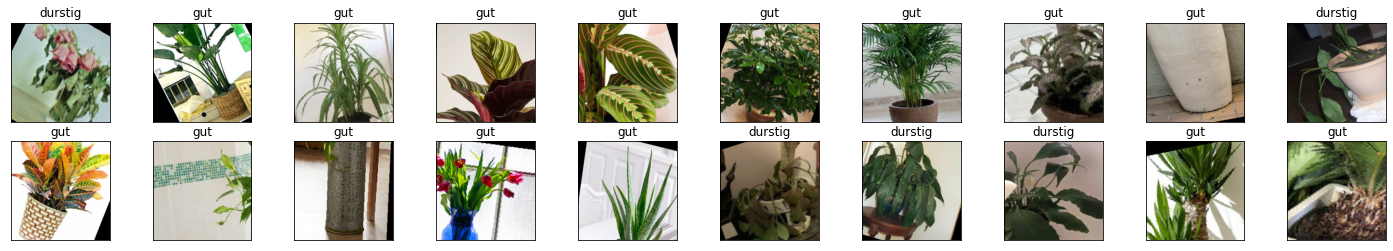

In [11]:
# specify the image classes
classes = ['gut', 'durstig']

# get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot some images with corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     plt.imshow(images[idx])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [13]:
model = models.densenet121(pretrained=True)

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will work on {device.type}.")

Model will work on cpu.


In [33]:
model.classifier = nn.Sequential(
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1)
                                )
# NLLLoss: The negative log likelihood loss.
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);